## Calculate the Effective Spring Constant During an Oscillation

### Modules being used

In [180]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct  8 10:48:11 2018

@author: thomas
"""

import os, shutil
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

### Constants

In [181]:
tstep = 5.0e-5
RADIUS = 0.15
RHO = 2.0
MASS = RHO*(4.0/3.0)*np.pi*RADIUS**3
print('mass = ',MASS)
St = 0.78
FREQ = 10.0
OMEGA = 2.0*np.pi*FREQ
AMP = RADIUS/St
#Plot Parameters
tstart = 2.0
tend = 2.1
FIGNUM = 0

mass =  0.02827433388230813


### Data Table Names

In [182]:
ForceString = 'fdRe30.0St0.78.txt'
PositionString = 'pdRe30.0St0.78.txt'

In [183]:
def main(ForceString, PositionString):
    global tstep, MASS, RADIUS, RHO, AMP, OMEGA
    #Create 'data' dataframe. Must include input values
    '''Read and import Force data file'''
    #Columns used by data.'NameofColumnHere'
    fd = pd.read_csv(ForceString,delimiter = ' ',names=['Fx0','Fy0','Fx1','Fy1','time'])
    fd = fd.dropna()
    fd = fd.sort_values(by=['time'])
    '''Read and import Position data file'''
    #Columns used by data.'NameofColumnHere'
    posd = pd.read_csv(PositionString,delimiter = ' ',names=['x0','y0','x1','y1','curr','des','time'])
    posd = posd.dropna()
    posd = posd.sort_values(by=['time'])
    posd.y1 += 0.75
    
    #Add new Columns to force database
    fd['NetFcorr1'], fd['NetFcorr0'] = 0.0,0.0
    fd['Keff1'], fd['Keff0'] = 0.0,0.0
    #display(fd)
    #Input Initial correction forces
    fd.at[0,'NetFcorr1'] = fd.at[0,'Fy1']
    fd.at[0,'NetFcorr0'] = fd.at[0,'Fy0']
    
    SSAnalysis(posd,fd)
    
    LSAnalysis(posd,fd)
    
    return

#------------------------__END MAIN__----------------------------

### Analysis Script for Small Sphere

In [184]:
def SSAnalysis(posd,fd):
    global tstep, MASS, RADIUS, RHO, AMP, OMEGA, tstart, tend, FIGNUM
    #This function will be used to analyze the position data as well as the force data
    
    #Calculate the effective spring constant for quarter oscillations
    tosc = 0.025
    NoscMax = int(3.0/tosc)
    #Create Numpy array of net forces per quarter oscillation
    NetForce1 = np.zeros((2,NoscMax))
    Keff1 = np.zeros(NoscMax)
    oscNum = np.arange(1,NoscMax+1,1)
    Ypos1 = np.zeros(NoscMax)
    for idx in range(NoscMax):
        maxTime = (idx+1)*tosc
        #print('maxTime = ',maxTime)
        NetForce1[0,idx] = np.sum(fd.Fx1[(fd.time <= maxTime) & (fd.time > maxTime - tosc)])
        NetForce1[1,idx] = np.sum(fd.Fy1[(fd.time <= maxTime) & (fd.time > maxTime - tosc)])
        Ypos1[idx] = posd.at[int(maxTime/tstep)-1,'y1']
        Keff1[idx] = NetForce1[1,idx]/AMP
        #print('NetForce[%i]'%idx)
        #print(NetForce1[:,idx])
        
    #Calculate Keff for each quarter oscillation
    #From 0 -> T/4
    KeffQ1 = np.zeros(int(NoscMax/4))
    timeQ1 = np.zeros(int(NoscMax/4))
    count = 0
    for idx1 in range(0,NoscMax,4):
        KeffQ1[count] = Keff1[idx1]
        timeQ1[count] = oscNum[idx1]*tosc
        count += 1
    #From T/4 -> T/2
    KeffQ2 = np.zeros(int(NoscMax/4))
    timeQ2 = np.zeros(int(NoscMax/4))
    count = 0
    for idx2 in range(1,NoscMax,4):
        KeffQ2[count] = Keff1[idx2]
        timeQ2[count] = oscNum[idx2]*tosc
        count += 1
    #From T/2 -> 3T/4
    KeffQ3 = np.zeros(int(NoscMax/4))
    timeQ3 = np.zeros(int(NoscMax/4))
    count = 0
    for idx3 in range(2,NoscMax,4):
        KeffQ3[count] = Keff1[idx3]
        timeQ3[count] = oscNum[idx3]*tosc
        count += 1
    #From 3T/4 -> T
    KeffQ4 = np.zeros(int(NoscMax/4))
    timeQ4 = np.zeros(int(NoscMax/4))
    count = 0
    for idx4 in range(3,NoscMax,4):
        KeffQ4[count] = Keff1[idx4]
        timeQ4[count] = oscNum[idx4]*tosc
        count += 1
    
    #Plot KeffQ1->4 vs oscNum
    fig = plt.figure(num=FIGNUM, figsize=(4,4),dpi=120)
    ax = fig.add_subplot(111)
    ax.set_title(r'Quarter Oscillation $K_{eff}$: Small Sphere')
    ax.set_xlabel('time (s)')
    ax.set_ylabel(r'$K_{eff}$ (N/m)')
    #0->T/4
    ax.plot(timeQ1,KeffQ1,label = '0->T/4')
    ax.scatter(timeQ1,KeffQ1,s=9)
    #T/4->T/2
    ax.plot(timeQ2,KeffQ2,label = 'T/4->T/2')
    ax.scatter(timeQ2,KeffQ2,s=9)
    #T/2->3T/4
    ax.plot(timeQ3,KeffQ3,label = 'T/2->3T/4')
    ax.scatter(timeQ3,KeffQ3,s=9)
    #3T/4->T
    ax.plot(timeQ4,KeffQ4,label = '3T/4->T')
    ax.scatter(timeQ4,KeffQ4,s=9)
    ax.legend(loc='upper right',fontsize='small')
    fig.tight_layout()
    plt.show()
    fig.clf()
    FIGNUM += 1
    
    #Calculate Average Keff for each quarter oscillation
    print('Small Sphere')
    print('='*40+'\n')
    print('Average Keff for Each Quarter!')
    #0->T/4 Q1
    print('Q1: 0->T/4')
    AvgKeffQ1 = np.mean(KeffQ1[1:])
    print('KeffQ1 = ',AvgKeffQ1)
    print('\n')
    #T/4->T/2
    print('Q2: T/4->T/2')
    AvgKeffQ2 = np.mean(KeffQ2[1:])
    print('KeffQ2 = ',AvgKeffQ2)
    print('\n')
    #T/2->3T/4
    print('Q3: T/2->3T/4')
    AvgKeffQ3 = np.mean(KeffQ3[1:])
    print('KeffQ3 = ',AvgKeffQ3)
    print('\n')
    #3T/4->T
    print('Q4: 3T/4->T')
    AvgKeffQ4 = np.mean(KeffQ4[1:])
    print('KeffQ4 = ',AvgKeffQ4)
    print('\n')
    print('-'*40)
    
        
    return

### Analysis Script for Large Sphere

In [185]:
def LSAnalysis(posd,fd):
    global tstep, MASS, RADIUS, RHO, AMP, OMEGA, tstart, tend, FIGNUM
    #This function will be used to analyze the position data as well as the force data
    
    LargeAmp = AMP*0.25
    #Calculate the effective spring constant for quarter oscillations
    tosc = 0.025
    NoscMax = int(3.0/tosc)
    #Create Numpy array of net forces per quarter oscillation
    NetForce0 = np.zeros((2,NoscMax))
    Keff0 = np.zeros(NoscMax)
    oscNum = np.arange(1,NoscMax+1,1)
    Ypos0 = np.zeros(NoscMax)
    for idx in range(NoscMax):
        maxTime = (idx+1)*tosc
        #print('maxTime = ',maxTime)
        NetForce0[0,idx] = np.sum(fd.Fx0[(fd.time <= maxTime) & (fd.time > maxTime - tosc)])
        NetForce0[1,idx] = np.sum(fd.Fy0[(fd.time <= maxTime) & (fd.time > maxTime - tosc)])
        Ypos0[idx] = posd.at[int(maxTime/tstep)-1,'y0']
        Keff0[idx] = NetForce0[1,idx]/LargeAmp
        #print('NetForce[%i]'%idx)
        #print(NetForce1[:,idx])
        
    #Calculate Average Keff for each quarter oscillation
    #From 0 -> T/4
    KeffQ1 = np.zeros(int(NoscMax/4))
    timeQ1 = np.zeros(int(NoscMax/4))
    count = 0
    for idx1 in range(0,NoscMax,4):
        KeffQ1[count] = Keff0[idx1]
        timeQ1[count] = oscNum[idx1]*tosc
        count += 1
    #From T/4 -> T/2
    KeffQ2 = np.zeros(int(NoscMax/4))
    timeQ2 = np.zeros(int(NoscMax/4))
    count = 0
    for idx2 in range(1,NoscMax,4):
        KeffQ2[count] = Keff0[idx2]
        timeQ2[count] = oscNum[idx2]*tosc
        count += 1
    #From T/2 -> 3T/4
    KeffQ3 = np.zeros(int(NoscMax/4))
    timeQ3 = np.zeros(int(NoscMax/4))
    count = 0
    for idx3 in range(2,NoscMax,4):
        KeffQ3[count] = Keff0[idx3]
        timeQ3[count] = oscNum[idx3]*tosc
        count += 1
    #From 3T/4 -> T
    KeffQ4 = np.zeros(int(NoscMax/4))
    timeQ4 = np.zeros(int(NoscMax/4))
    count = 0
    for idx4 in range(3,NoscMax,4):
        KeffQ4[count] = Keff0[idx4]
        timeQ4[count] = oscNum[idx4]*tosc
        count += 1
    
    #Plot KeffQ1->4 vs oscNum
    fig = plt.figure(num=FIGNUM, figsize=(4,4),dpi=120)
    ax = fig.add_subplot(111)
    ax.set_title(r'Quarter Oscillation $K_{eff}$: Large Sphere')
    ax.set_xlabel('time (s)')
    ax.set_ylabel(r'4$K_{eff}$ (N/m)')
    #0->T/4
    ax.plot(timeQ1,KeffQ1,label = '0->T/4')
    ax.scatter(timeQ1,KeffQ1,s=9)
    #T/4->T/2
    ax.plot(timeQ2,KeffQ2,label = 'T/4->T/2')
    ax.scatter(timeQ2,KeffQ2,s=9)
    #T/2->3T/4
    ax.plot(timeQ3,KeffQ3,label = 'T/2->3T/4')
    ax.scatter(timeQ3,KeffQ3,s=9)
    #3T/4->T
    ax.plot(timeQ4,KeffQ4,label = '3T/4->T')
    ax.scatter(timeQ4,KeffQ4,s=9)
    ax.legend(loc='upper right',fontsize='small')
    fig.tight_layout()
    plt.show()
    fig.clf()
    FIGNUM += 1
    
    #Calculate Average Keff for each quarter oscillation
    print('Large Sphere')
    print('='*40+'\n')
    print('Average Keff for Each Quarter!')
    #0->T/4 Q1
    print('Q1: 0->T/4')
    AvgKeffQ1 = np.mean(KeffQ1[1:])
    print('KeffQ1 = ',AvgKeffQ1)
    print('\n')
    #T/4->T/2
    print('Q2: T/4->T/2')
    AvgKeffQ2 = np.mean(KeffQ2[1:])
    print('KeffQ2 = ',AvgKeffQ2)
    print('\n')
    #T/2->3T/4
    print('Q3: T/2->3T/4')
    AvgKeffQ3 = np.mean(KeffQ3[1:])
    print('KeffQ3 = ',AvgKeffQ3)
    print('\n')
    #3T/4->T
    print('Q4: 3T/4->T')
    AvgKeffQ4 = np.mean(KeffQ4[1:])
    print('KeffQ4 = ',AvgKeffQ4)
    print('\n')
    print('-'*40)
        
    return

## Re=10; St = 0.78

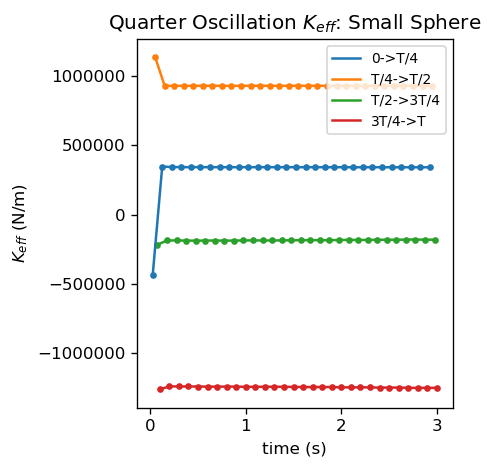

Small Sphere

Average Keff for Each Quarter!
Q1: 0->T/4
KeffQ1 =  343266.020689


Q2: T/4->T/2
KeffQ2 =  931714.966359


Q3: T/2->3T/4
KeffQ3 =  -184576.175316


Q4: 3T/4->T
KeffQ4 =  -1246633.2259


----------------------------------------


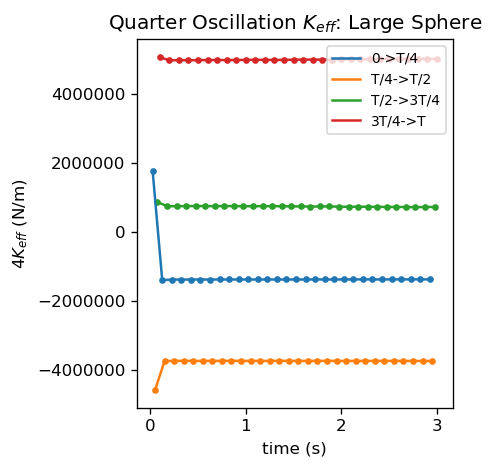

Large Sphere

Average Keff for Each Quarter!
Q1: 0->T/4
KeffQ1 =  -1373064.08276


Q2: T/4->T/2
KeffQ2 =  -3726859.86543


Q3: T/2->3T/4
KeffQ3 =  738304.701265


Q4: 3T/4->T
KeffQ4 =  4986532.90361


----------------------------------------


In [186]:
Re = 10.0
St = 0.78
AMP = RADIUS/St
ForceString = 'fdRe10.0St0.78.txt'
PositionString = 'pdRe10.0St0.78.txt'
main(ForceString, PositionString)

## Re=10; St = 1.56

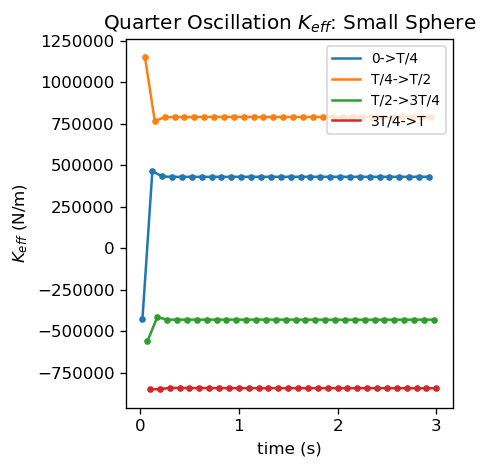

Small Sphere

Average Keff for Each Quarter!
Q1: 0->T/4
KeffQ1 =  432003.167685


Q2: T/4->T/2
KeffQ2 =  790173.267771


Q3: T/2->3T/4
KeffQ3 =  -428754.335679


Q4: 3T/4->T
KeffQ4 =  -841794.295967


----------------------------------------


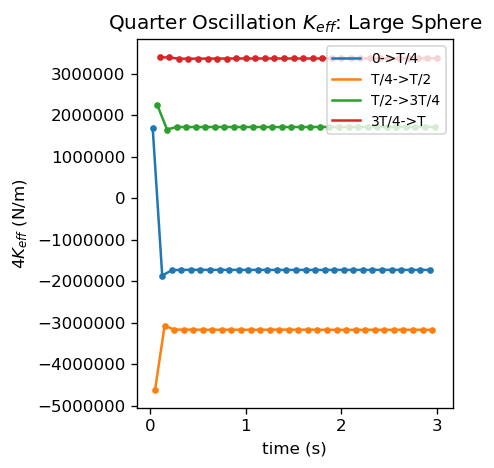

Large Sphere

Average Keff for Each Quarter!
Q1: 0->T/4
KeffQ1 =  -1728012.67074


Q2: T/4->T/2
KeffQ2 =  -3160693.07108


Q3: T/2->3T/4
KeffQ3 =  1715017.34271


Q4: 3T/4->T
KeffQ4 =  3367177.18387


----------------------------------------


In [187]:
Re = 10.0
St = 1.56
AMP = RADIUS/St
ForceString = 'fdRe10.0St1.56.txt'
PositionString = 'pdRe10.0St1.56.txt'
main(ForceString, PositionString)

## Re=30; St = 0.78

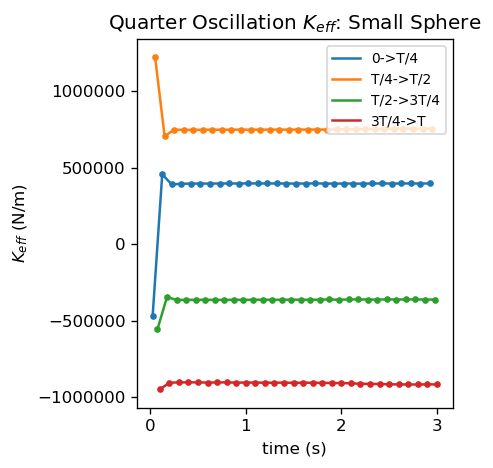

Small Sphere

Average Keff for Each Quarter!
Q1: 0->T/4
KeffQ1 =  400156.003694


Q2: T/4->T/2
KeffQ2 =  750890.53581


Q3: T/2->3T/4
KeffQ3 =  -360537.89426


Q4: 3T/4->T
KeffQ4 =  -906989.509687


----------------------------------------


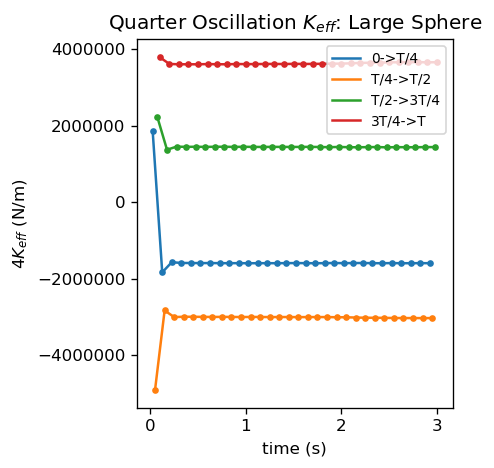

Large Sphere

Average Keff for Each Quarter!
Q1: 0->T/4
KeffQ1 =  -1600624.01478


Q2: T/4->T/2
KeffQ2 =  -3003562.14324


Q3: T/2->3T/4
KeffQ3 =  1442151.57704


Q4: 3T/4->T
KeffQ4 =  3627958.03875


----------------------------------------


In [188]:
Re = 30.0
St = 0.78
AMP = RADIUS/St
ForceString = 'fdRe30.0St0.78.txt'
PositionString = 'pdRe30.0St0.78.txt'
main(ForceString, PositionString)

## Re=30; St = 1.56

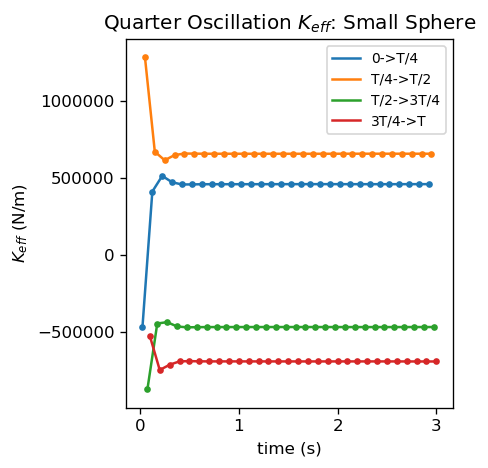

Small Sphere

Average Keff for Each Quarter!
Q1: 0->T/4
KeffQ1 =  459883.699924


Q2: T/4->T/2
KeffQ2 =  655059.42997


Q3: T/2->3T/4
KeffQ3 =  -463344.489904


Q4: 3T/4->T
KeffQ4 =  -690282.626139


----------------------------------------


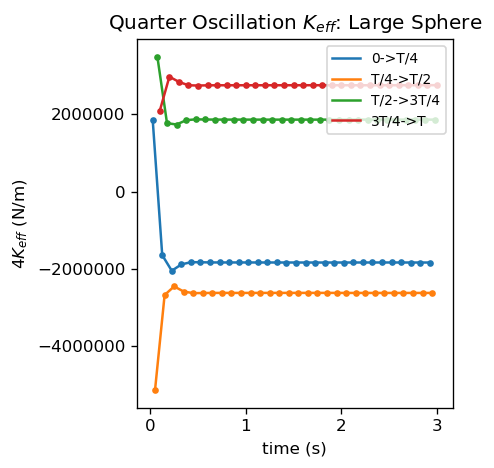

Large Sphere

Average Keff for Each Quarter!
Q1: 0->T/4
KeffQ1 =  -1839534.7997


Q2: T/4->T/2
KeffQ2 =  -2620237.71988


Q3: T/2->3T/4
KeffQ3 =  1853377.95962


Q4: 3T/4->T
KeffQ4 =  2761130.50456


----------------------------------------


In [189]:
Re = 30.0
St = 1.56
AMP = RADIUS/St
ForceString = 'fdRe30.0St1.56.txt'
PositionString = 'pdRe30.0St1.56.txt'
main(ForceString, PositionString)

## ===========================
## Summary of Keff Findings
### In general, we notice the following trends. 
### Call this K1: During the spherobot's oscillation, when it is returning to its equilibrium/starting position (quarter oscillations T/4->T/2 and 3T/4->T), more force is needed. In return Keff is larger
### Call this K2: When it is approaching maximum displacement (quarter oscillations 0->T/4 and T/2->3T/4), less force is needed. Keff is smaller
### As Re increases, K1 and K2 decrease
### As the Amplitude increases or St decreases, K1 increases but K2 decreases
### The large sphere Keff is much larger than the small sphere (4x larger)
## ----------------------------------------

## Reported K Values in Simulations

## ==============================
### PRL Simulations K-values
### Nu = 1000.0; K = 100,000,000.0
### Nu = 100.0; K = 10,000,000.0
### Nu = 20.0; K = 2,000,000.0
### Nu = 10.0; K = 1,000,000.0
### Nu = 4.0; K = 200,000.0 
### Nu = 2; K = 100,000.0
### 1.12 < Nu < 2 : K = 75,000.0
### Nu <= 1.12: K = 50,000.0
## --------------------------------------------

## ==============================
### Transition Sweep K-values (Simulation data being shown)
### Re = [10.0,30.0]
### St = [0.78, 1.56]
### K = 250,000.0
## --------------------------------------------

### Keff vs Re

In [190]:
#Plotting Keff vs Re for both the large and small sphere